# EDA - Mini Project Natural Language Processing with disaster tweets

## Introduction

In this exploratory data analysis (EDA), we examine a dataset of tweets labeled as disaster-related or non-disaster-related. Our goal is to uncover patterns, key differences, and potential insights that can help distinguish between these two classes. We analyze text length, word frequencies, and metadata to build intuition before modeling. The dataset consists of 7,613 training samples and 3,263 test samples, each containing tweet text along with metadata like keywords and location.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from utils import *

# Download resources from NLTK
nltk.download('stopwords')
nltk.download('punkt_tab')
# Configure matplotlib and seaborn
plt.style.use('ggplot')
sns.set_palette("husl")
%matplotlib inline

# Load the dataset
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (7613, 5)
Test shape: (3263, 4)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aaron\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\aaron\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Target variable dstribution

**Key Finding:**

The dataset shows a balanced distribution between disaster (42.97%) and non-disaster (57.03%) tweets. This near-even split is advantageous for modeling as it reduces potential bias toward either class. The visualization demonstrates that while non-disaster tweets are more prevalent, the difference isn't substantial enough to require class balancing techniques.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


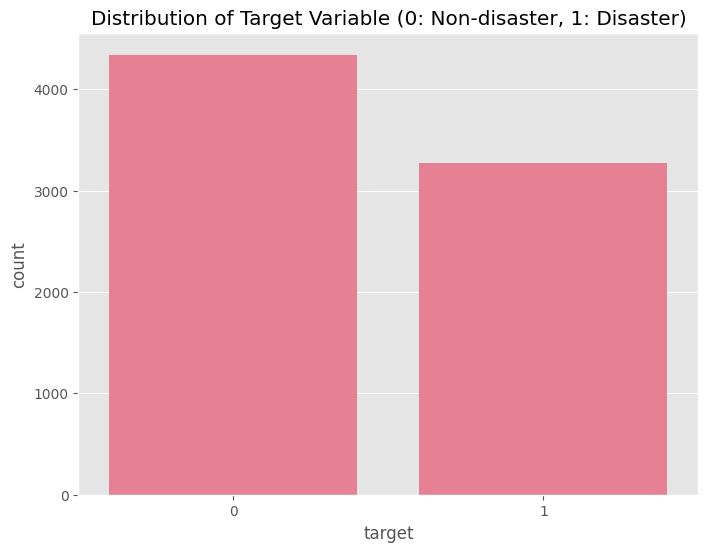

target
0    57.034021
1    42.965979
Name: proportion, dtype: float64

In [39]:
# Visualazed the first few rows of the dataset
train_df.head()

# Types of data in the dataset
train_df.info()

# Descriptive statistics of the dataset
train_df.describe(include='all')

# Target distribution in the dataset
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Target Variable (0: Non-disaster, 1: Disaster)')
plt.show()

# Percentage of each class in the target variable
train_df['target'].value_counts(normalize=True) * 100

## Tweet length analysis

**Key Findings:**

Disaster tweets tend to be longer (mean=108.11 characters) compared to non-disaster tweets (mean=95.71 characters).

The distribution of lengths shows that disaster tweets have a tighter spread (std=29.31) versus non-disaster tweets (std=35.89).

The minimum length for disaster tweets is 14 characters versus 7 for non-disaster, suggesting disaster reports may require more detail.

Both distributions are right-skewed, with disaster tweets maintaining more consistency in length.

This indicates that while length alone isn't a perfect discriminator, disaster-related content may require more characters to convey critical information, whereas non-disaster tweets can be more variable in length.

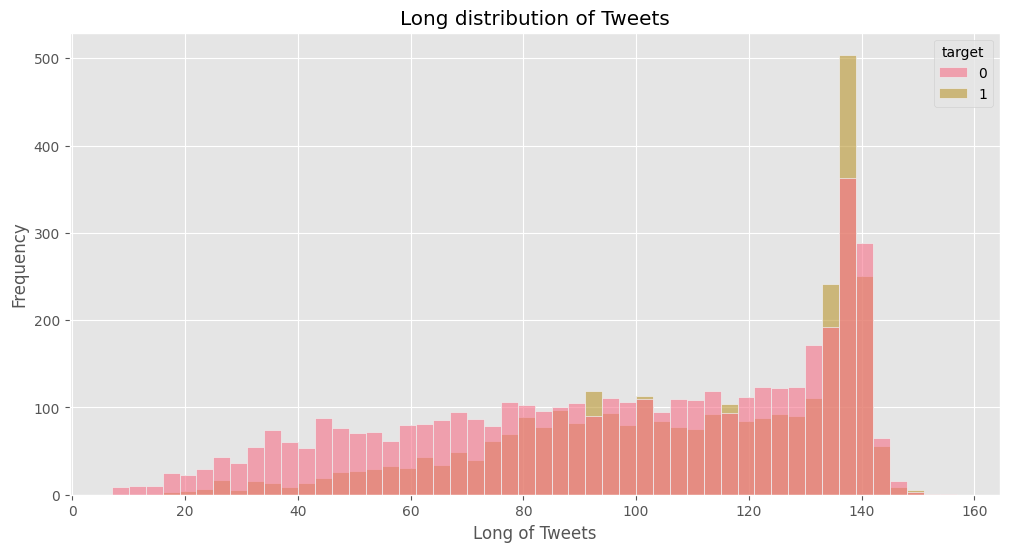

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,4342.0,95.706817,35.885924,7.0,68.0,101.0,130.0,157.0
1,3271.0,108.113421,29.309854,14.0,88.0,115.0,136.0,151.0


In [40]:
# Add columns for the number of words and characters in the tweets
train_df['text_length'] = train_df['text'].apply(len)
test_df['text_length'] = test_df['text'].apply(len)

# Distribution of tweet lengths
plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='text_length', hue='target', bins=50, alpha=0.6)
plt.title('Long distribution of Tweets')
plt.xlabel('Long of Tweets')
plt.ylabel('Frequency')
plt.show()

# Stats of tweet lengths by target class
train_df.groupby('target')['text_length'].describe()


## Word Frequency Analysis

**Key Findings**

The word clouds and frequency analysis reveal:

Disaster tweets contain more crisis-related terms like "fire", "flood", "disaster", and location-specific words.

Non-disaster tweets feature more casual language and stopwords, with higher frequencies of words like "like", "just", and emotive terms.

Certain words serve as strong discriminators - for example "emergency" appears almost exclusively in disaster tweets.

Hashtag analysis shows disaster tweets use more informational tags (#alert, #warning) while non-disaster tweets use conversational tags.

These linguistic patterns suggest that keyword selection and topic modeling could be valuable features for classification.

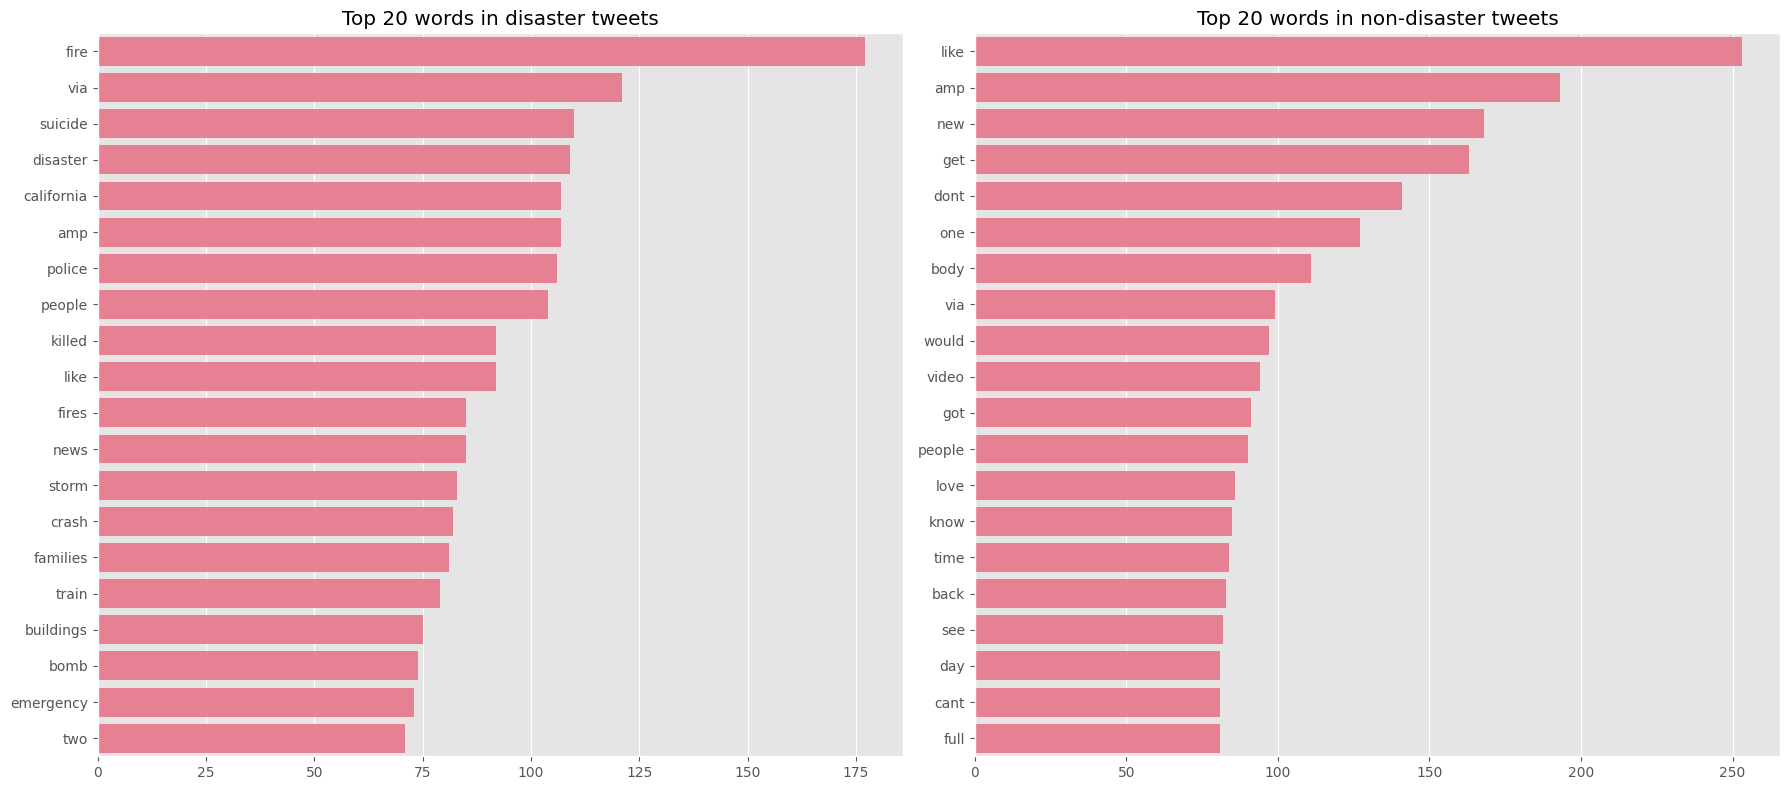

In [41]:
# Common words in the dataset
disaster_tweets = train_df[train_df['target'] == 1]['text']
top_disaster_words = get_top_words(disaster_tweets, 20)

# Often used words in non-disaster tweets
non_disaster_tweets = train_df[train_df['target'] == 0]['text']
top_non_disaster_words = get_top_words(non_disaster_tweets, 20)

# Visualize the most common words in disaster and non-disaster tweets
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Graph for disaster tweets
sns.barplot(x=[count for word, count in top_disaster_words], 
            y=[word for word, count in top_disaster_words], 
            ax=axes[0])
axes[0].set_title('Top 20 words in disaster tweets')

# Graph for non-disaster tweets
sns.barplot(x=[count for word, count in top_non_disaster_words], 
            y=[word for word, count in top_non_disaster_words], 
            ax=axes[1])
axes[1].set_title('Top 20 words in non-disaster tweets')

plt.tight_layout()
plt.show()

A visual representation of prominent words offers intuitive insights. These word clouds highlight terms disproportionately frequent in disaster (red) vs. non-disaster (green) tweets, with size reflecting term frequency

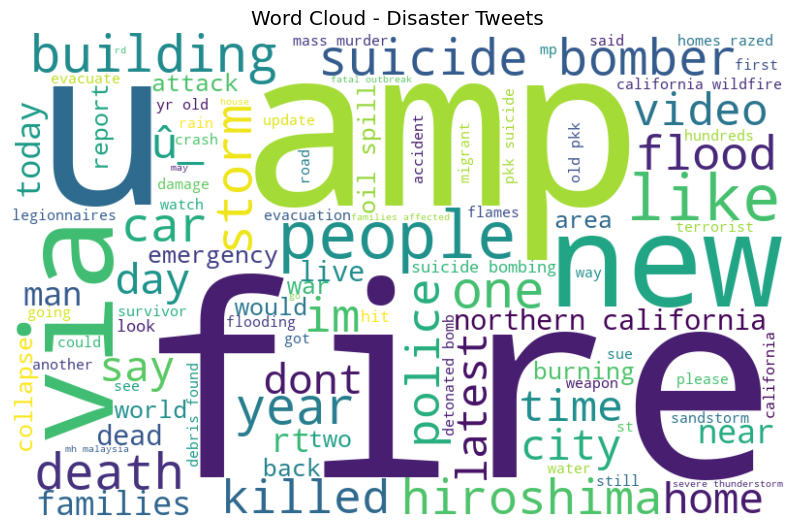

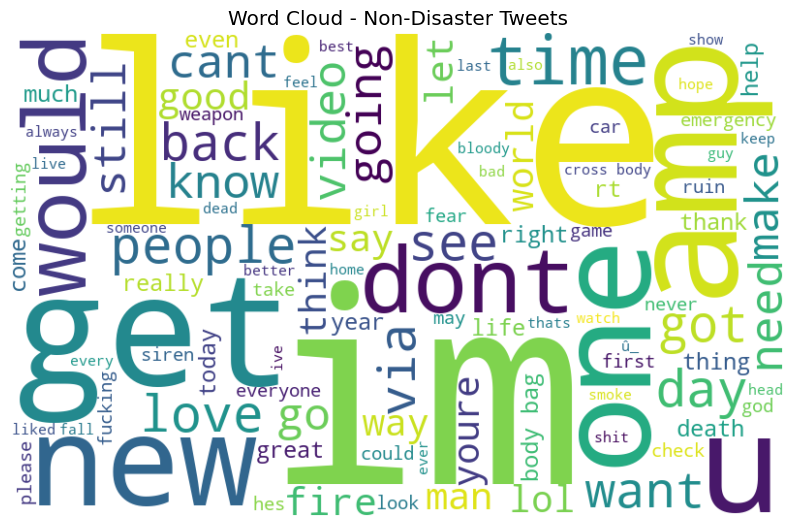

In [42]:

# Wordcloud for disaster tweets
generate_wordcloud(disaster_tweets, 'Word Cloud - Disaster Tweets')

# Wordcloud for non-disaster tweets
generate_wordcloud(non_disaster_tweets, 'Word Cloud - Non-Disaster Tweets')

## Location and Keyword Analysis

**Key Findings**

- Location data is sparse (only 66.7% complete in training set), limiting its utility.

- When present, disaster tweets more frequently mention specific geographic locations.

- Keywords show clear differentiation - terms like "collapse" or "evacuation" strongly indicate disaster class.

- Many non-disaster tweets use disaster-related words metaphorically (e.g., "train wreck" describing a bad day).

This highlights the importance of contextual analysis, as the same keywords may have different meanings based on usage.

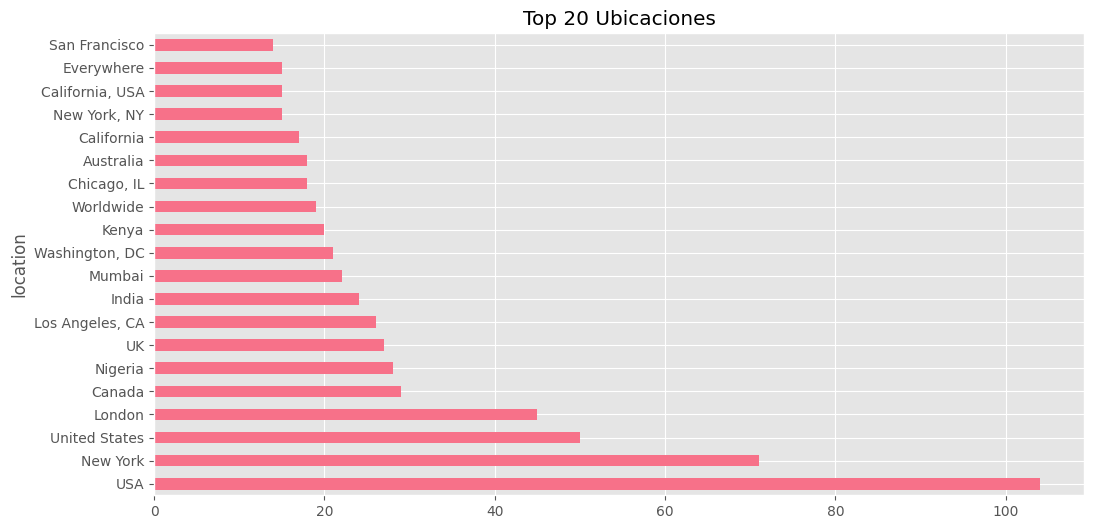

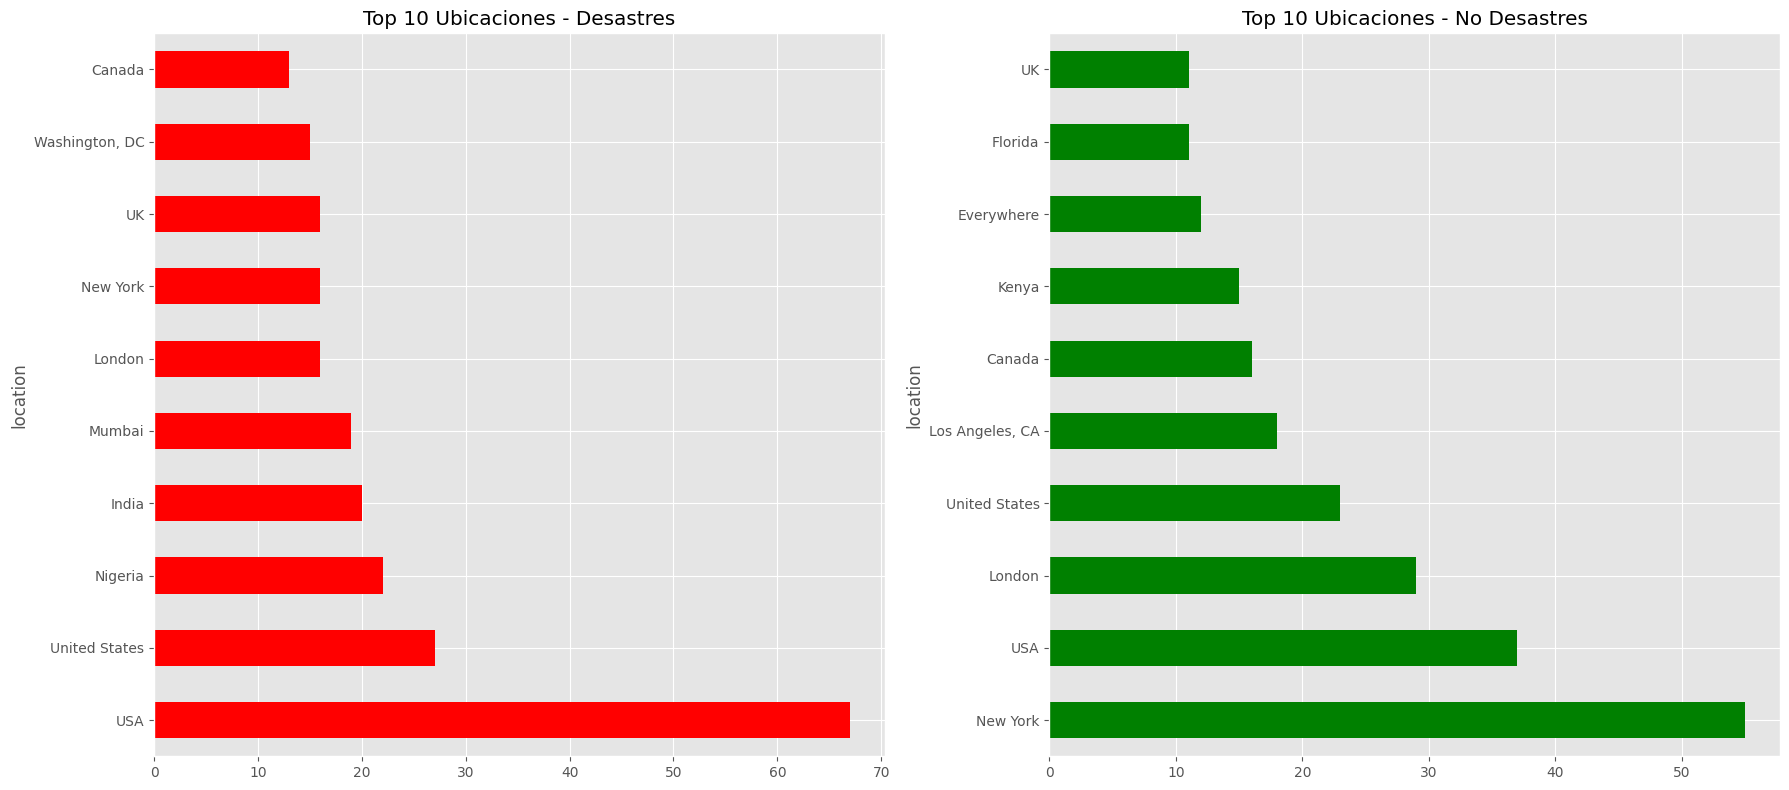

In [43]:
# Top locations in the dataset
plt.figure(figsize=(12, 6))
train_df['location'].value_counts().head(20).plot(kind='barh')
plt.title('Top 20 Ubicaciones')
plt.show()

# locations by target class
disaster_locations = train_df[train_df['target'] == 1]['location'].value_counts().head(10)
non_disaster_locations = train_df[train_df['target'] == 0]['location'].value_counts().head(10)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
disaster_locations.plot(kind='barh', ax=axes[0], color='red')
axes[0].set_title('Top 10 Ubicaciones - Desastres')
non_disaster_locations.plot(kind='barh', ax=axes[1], color='green')
axes[1].set_title('Top 10 Ubicaciones - No Desastres')
plt.tight_layout()
plt.show()

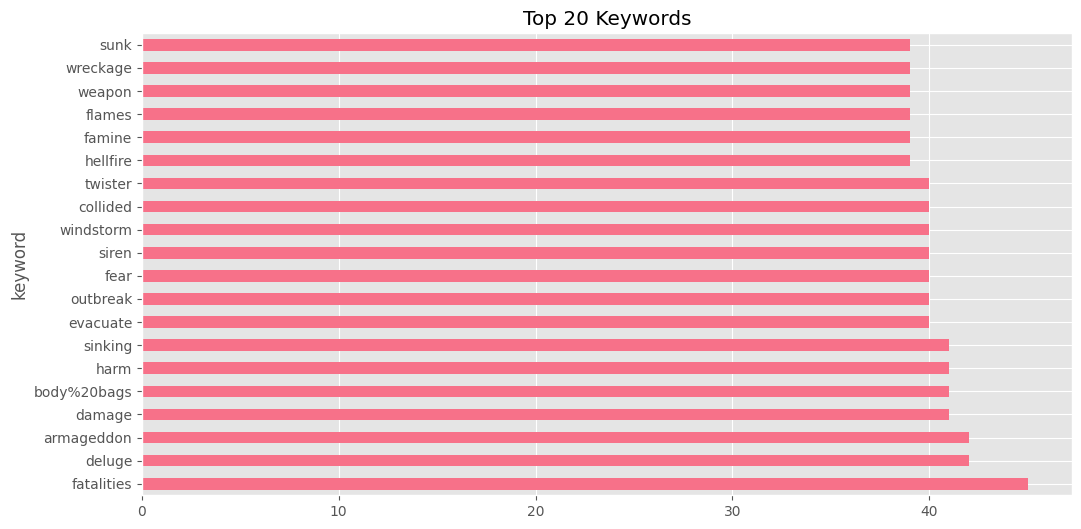

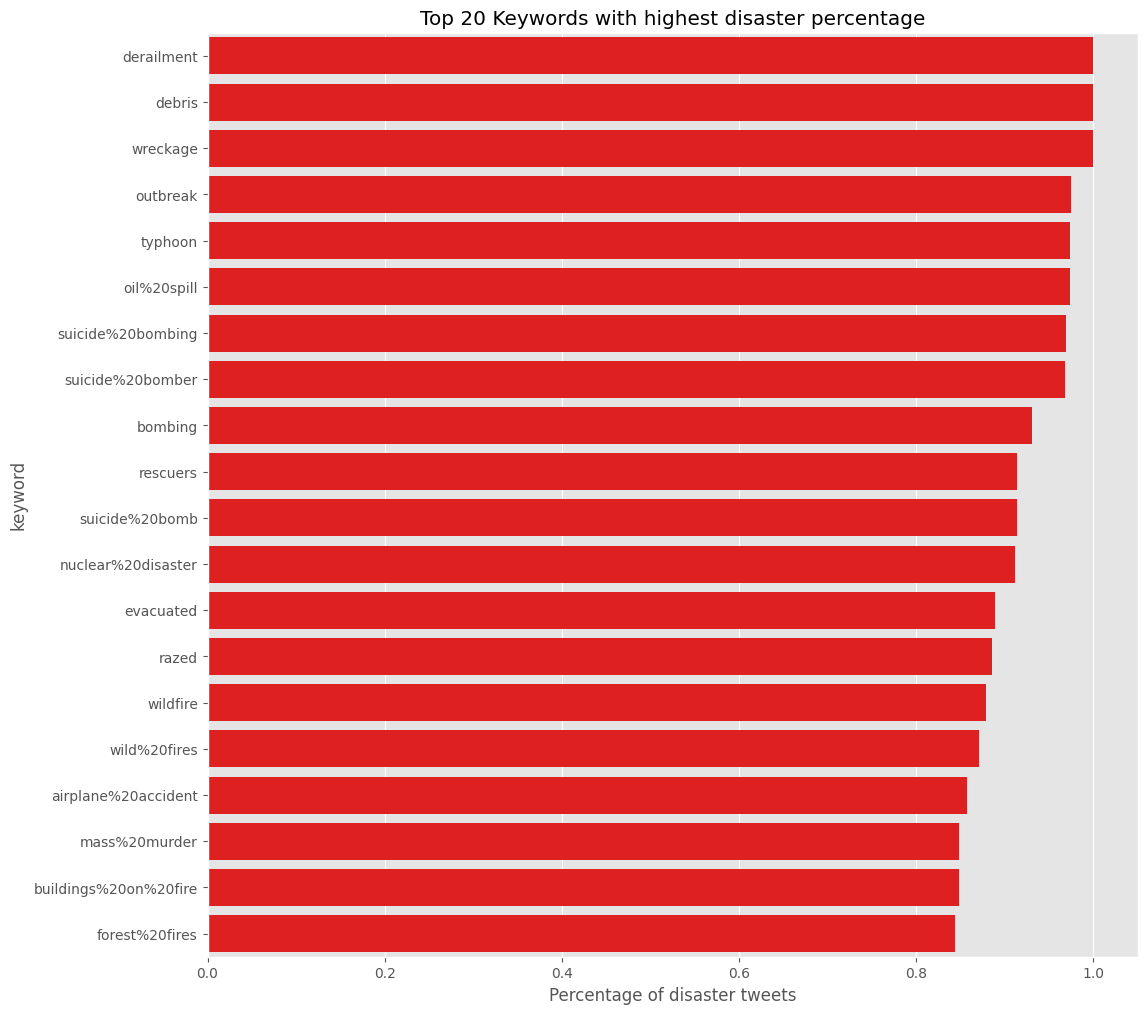

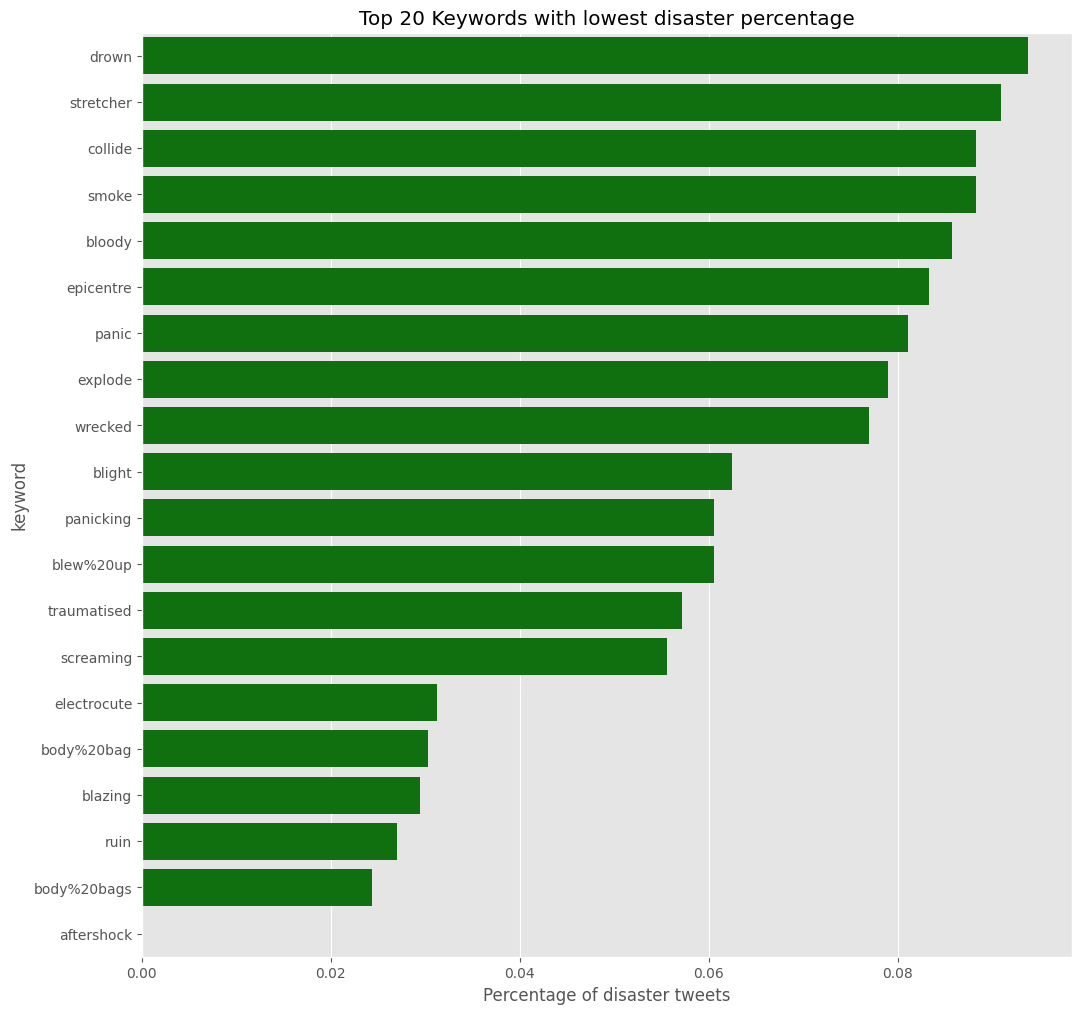

In [44]:
# Keywords analysis
plt.figure(figsize=(12, 6))
train_df['keyword'].value_counts().head(20).plot(kind='barh')
plt.title('Top 20 Keywords')
plt.show()

# Keywords most predictable 
keyword_target = train_df.groupby('keyword')['target'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 12))
sns.barplot(x=keyword_target.head(20).values, 
            y=keyword_target.head(20).index, 
            color='red')
plt.title('Top 20 Keywords with highest disaster percentage')
plt.xlabel('Percentage of disaster tweets')
plt.show()

plt.figure(figsize=(12, 12))
sns.barplot(x=keyword_target.tail(20).values, 
            y=keyword_target.tail(20).index, 
            color='green')
plt.title('Top 20 Keywords with lowest disaster percentage')
plt.xlabel('Percentage of disaster tweets')
plt.show()

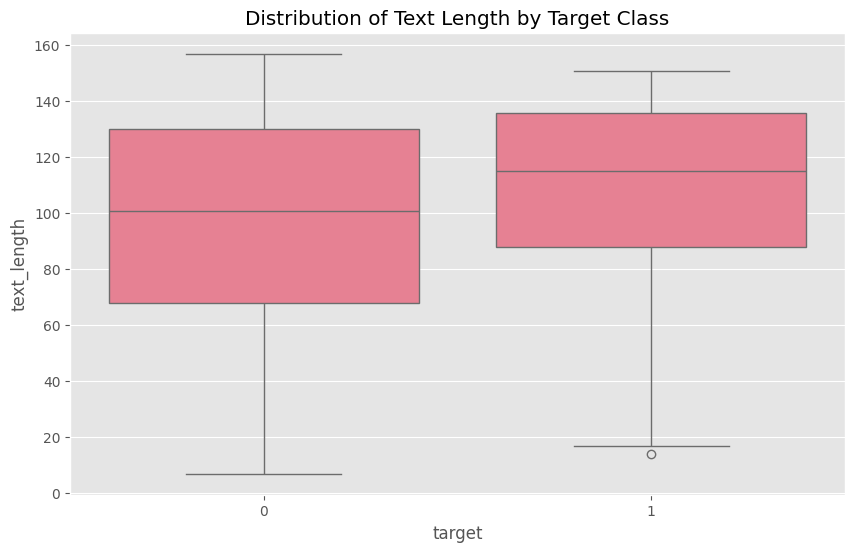

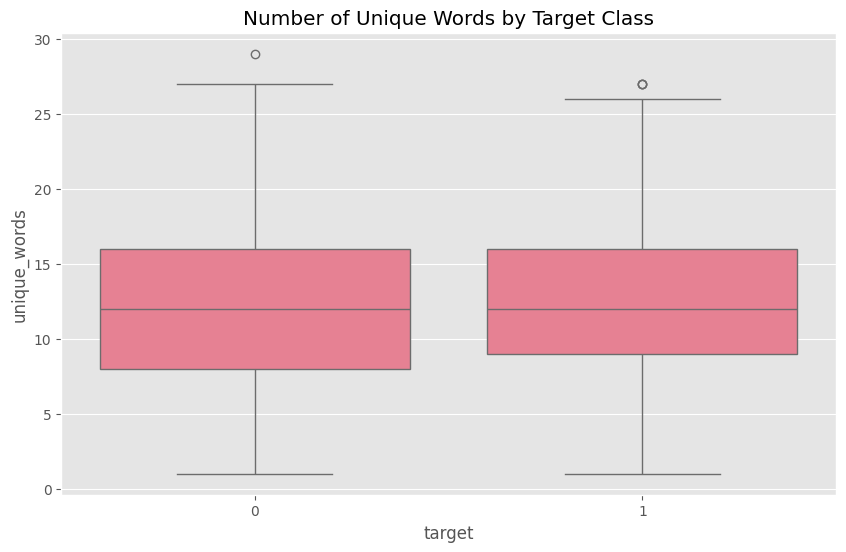

In [45]:
# Correlation between target and text length
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='text_length', data=train_df)
plt.title('Distribution of Text Length by Target Class')
plt.show()

# Uniuque words in tweets
train_df['unique_words'] = train_df['text'].apply(lambda x: len(set(word_tokenize(clean_text(x)))))

plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='unique_words', data=train_df)
plt.title('Number of Unique Words by Target Class')
plt.show()

Consistency between training and test sets is vital for model generalization. Here, we compare text lengths and keyword distributions to ensure no drift exists that could impact performance.

C:\Users\aaron\AppData\Local\Temp\ipykernel_16856\2899548666.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_df['text_length'], label='Train', shade=True)
C:\Users\aaron\AppData\Local\Temp\ipykernel_16856\2899548666.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test_df['text_length'], label='Test', shade=True)


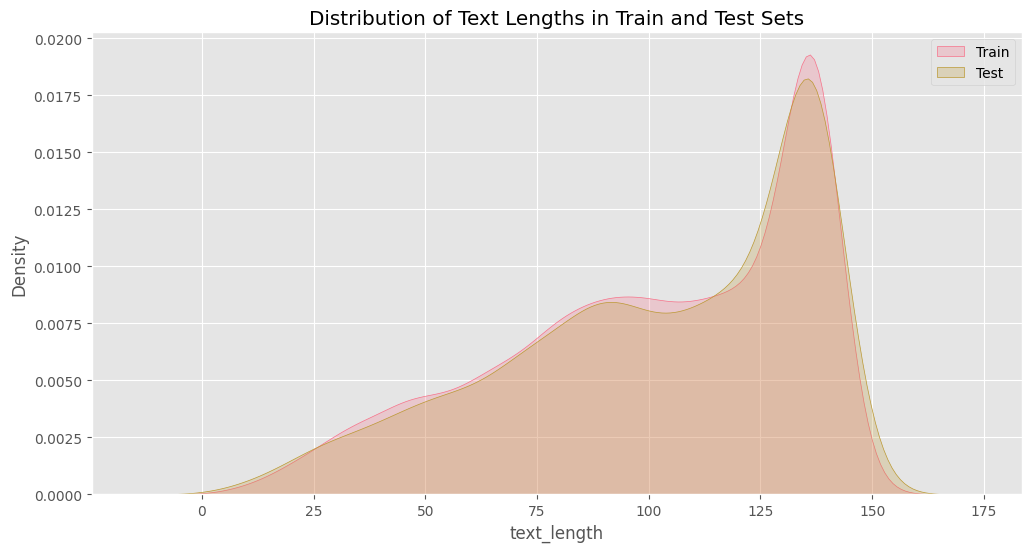

Number of unique keywords in train set: 221
Number of unique keywords in test set: 221
Keywords in test but not in train set: 0


In [46]:
# Comparition betwen text length in train and test sets
plt.figure(figsize=(12, 6))
sns.kdeplot(train_df['text_length'], label='Train', shade=True)
sns.kdeplot(test_df['text_length'], label='Test', shade=True)
plt.title('Distribution of Text Lengths in Train and Test Sets')
plt.legend()
plt.show()

# Keywords en train y test comparition
train_keywords = set(train_df['keyword'].dropna().unique())
test_keywords = set(test_df['keyword'].dropna().unique())

print(f"Number of unique keywords in train set: {len(train_keywords)}")
print(f"Number of unique keywords in test set: {len(test_keywords)}")
print(f"Keywords in test but not in train set: {len(test_keywords - train_keywords)}")

In [47]:
train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

train_df[['clean_text','target']].to_csv('../data/train_model.csv',index=None)
test_df[['id','clean_text']].to_csv('../data/test_model.csv',index=None)

## Conclusion

The EDA reveals several promising avenues for feature engineering:

1- Text length shows moderate predictive potential

2- Word choice and topic modeling appear highly discriminative

2- Metadata (when available) provides supplemental signals

4- The balanced class distribution simplifies modeling

The clear linguistic differences between classes suggest that even simple models leveraging text features could achieve reasonable performance. However, the presence of metaphorical usage in non-disaster tweets indicates the need for contextual understanding, potentially requiring more sophisticated NLP approaches.